# Imports and define expectation func

In [15]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [16]:
import torch
from FittedModels.utils import plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
import pathlib
from datetime import datetime
torch.set_default_dtype(torch.float64)

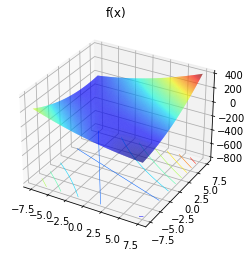

In [17]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [20]:
epochs = int(3e3)
batch_size = int(1e3)
dim = 10
n_samples_estimation = int(5e6)
KPI_n_samples = int(1e4)
lr = 1e-4
optimizer = "Adamax"
flow_type = "IAF" #"RealNVP"
n_flow_steps = 3  # 5
prior_scaling_factor = 10.0

In [19]:
torch.manual_seed(0)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
print(target.covs.device)
true_expectation = MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)) # print twice to make sure estimates are resonably close
target.to("cuda")
print(target.covs.device)

cpu
tensor(20.8094)
tensor(20.8046)
cuda:0


## Small Test of IAF speed vs RealNVP Speed
IAF roughly 50% slower at 10 dimensions

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
history = tester.train(50, batch_size=100, clip_grad=True, max_grad_norm=1)

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
history = tester.train(50, batch_size=100, clip_grad=True, max_grad_norm=1)

# DReG, alpha=1, then alpha = 2

In [28]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG_kl",
                                   lr=lr, optimizer=optimizer, k=50)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

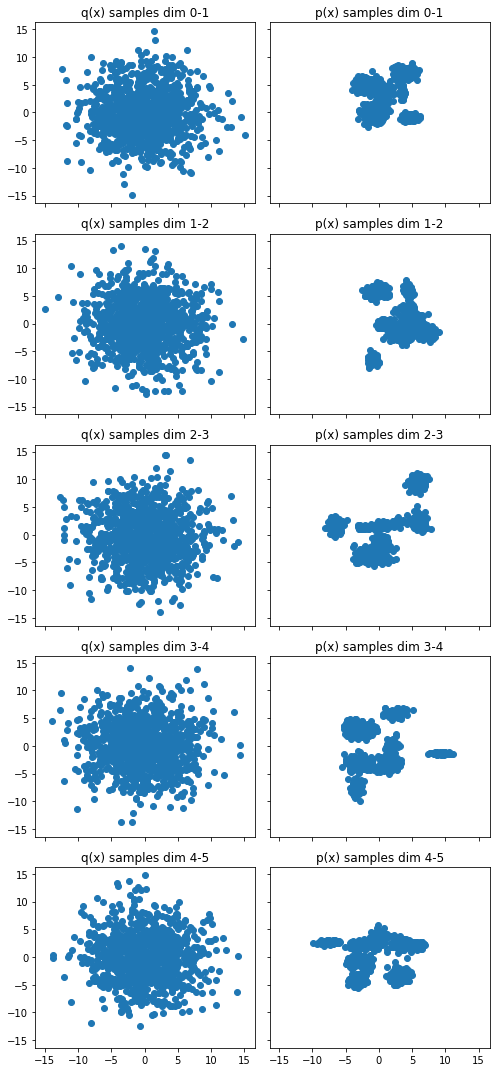

In [29]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [30]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [31]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 56.08662323558063 
estimate after training is 44.06544488841415 
effective sample size before is 2.0345173830306095e-06
effective sample size after train is 1.2269241033536552e-06
variance in weights is 3.260182012108196e-08


In [32]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 56.08662323558063 
estimate after training is 44.06544488841415 
effective sample size before is 2.0345173830306095e-06
effective sample size after train is 1.2269241033536552e-06
variance in weights is 3.260182012108196e-08


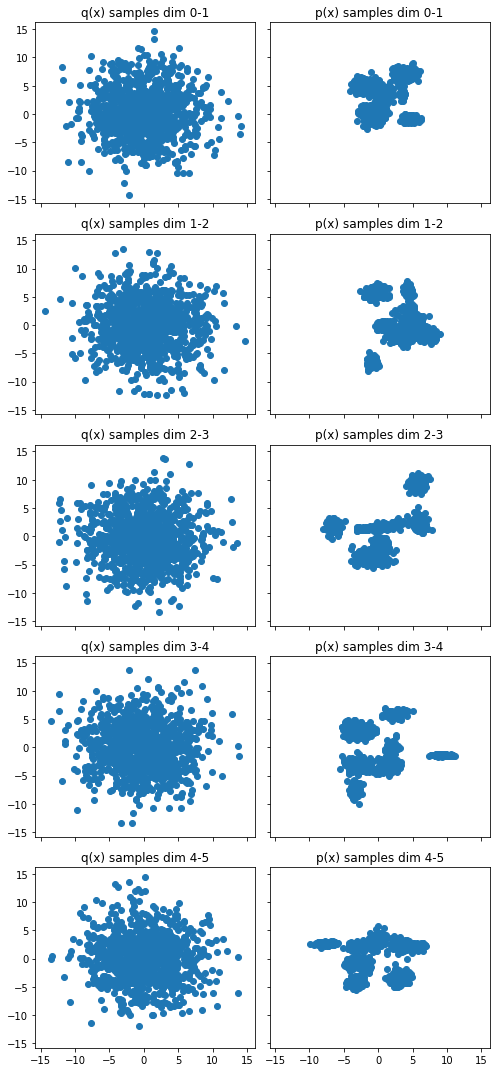

In [33]:
samples_fig_after = plot_samples(tester)

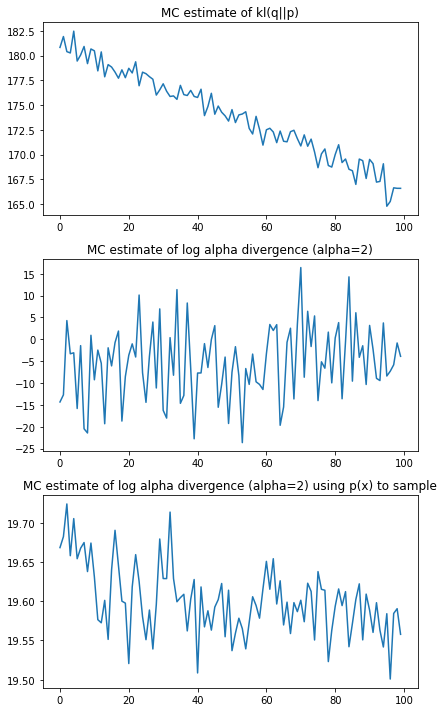

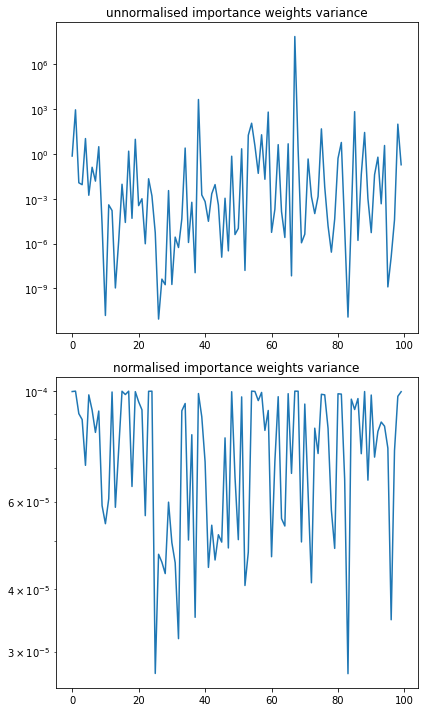

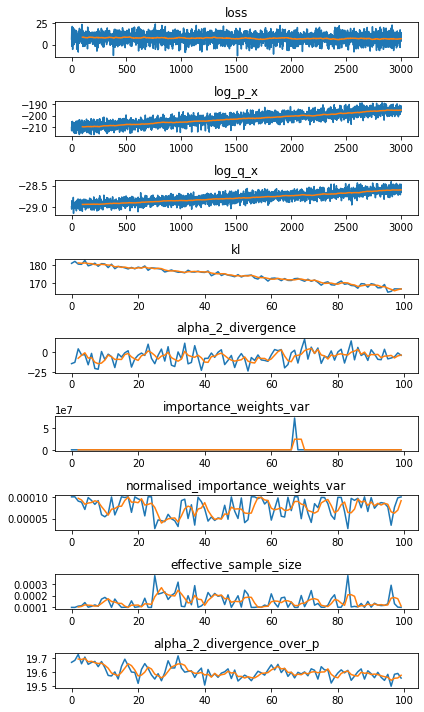

In [34]:
plot_divergences(history)
plot_sampling_info(history)
hist_plot = plot_history(history)

## Now change to DReG alpha=2 loss

In [35]:
tester.setup_loss("DReG")

In [36]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [37]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 56.08662323558063 
estimate after training is 34.08750123610041 
effective sample size before is 2.0345173830306095e-06
effective sample size after train is 4.443719520366031e-07
variance in weights is 9.00146601216881e-08


In [38]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 56.08662323558063 
estimate after training is 34.08750123610041 
effective sample size before is 2.0345173830306095e-06
effective sample size after train is 4.443719520366031e-07
variance in weights is 9.00146601216881e-08


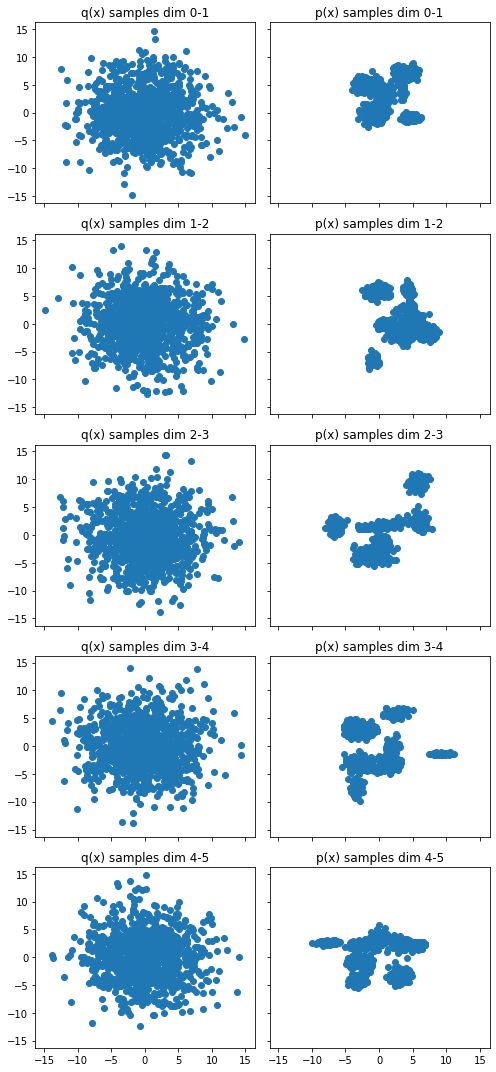

In [39]:
samples_fig_after = plot_samples(tester)

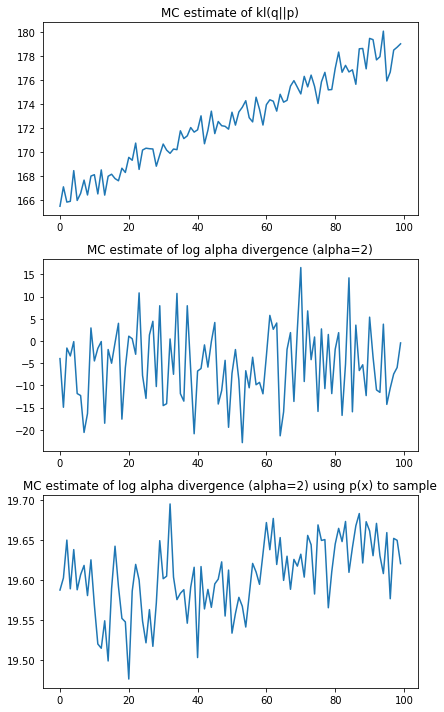

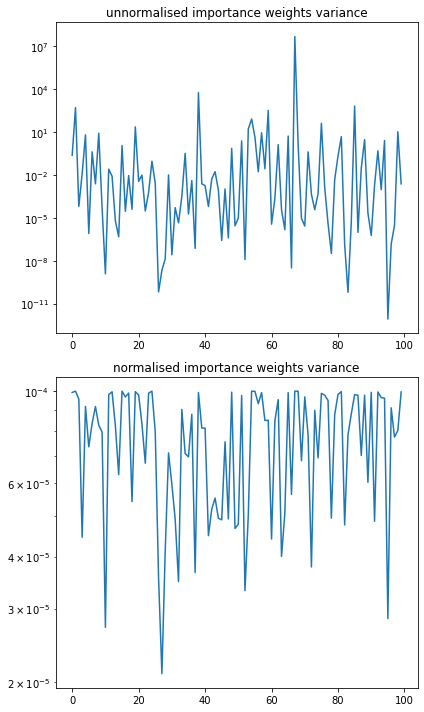

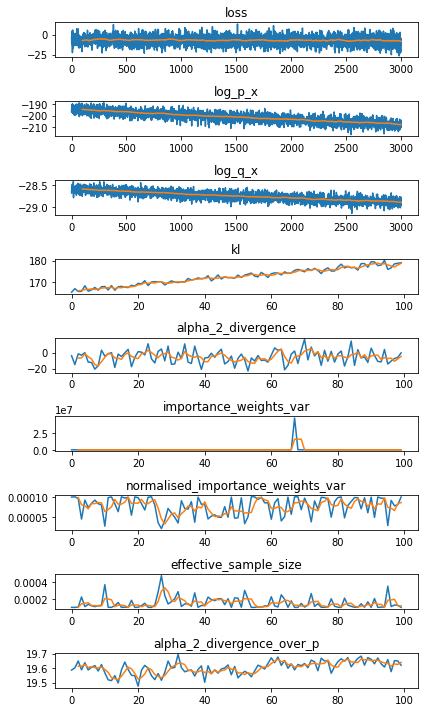

In [40]:
plot_divergences(history)
plot_sampling_info(history)
hist_plot = plot_history(history)

# DReG, alpha=2

In [21]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG",
                                   lr=lr, optimizer=optimizer)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

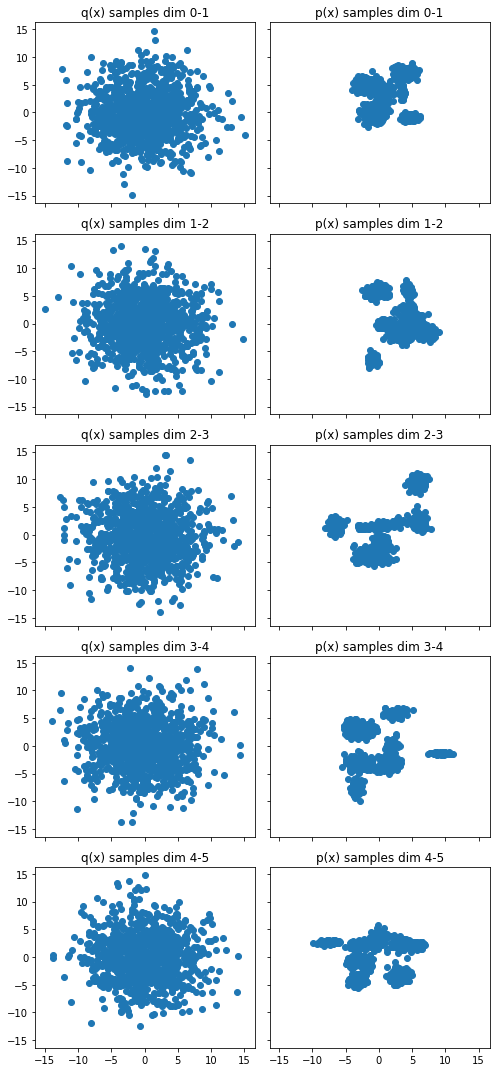

In [22]:
samples_fig_before = plot_samples(tester)

In [23]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=0.1)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [24]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 56.08662323558063 
estimate after training is 77.00234592582245 
effective sample size before is 2.0345173830306095e-06
effective sample size after train is 4.421333182402023e-07
variance in weights is 9.047042751830443e-08


In [25]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 56.08662323558063 
estimate after training is 77.00234592582245 
effective sample size before is 2.0345173830306095e-06
effective sample size after train is 4.421333182402023e-07
variance in weights is 9.047042751830443e-08


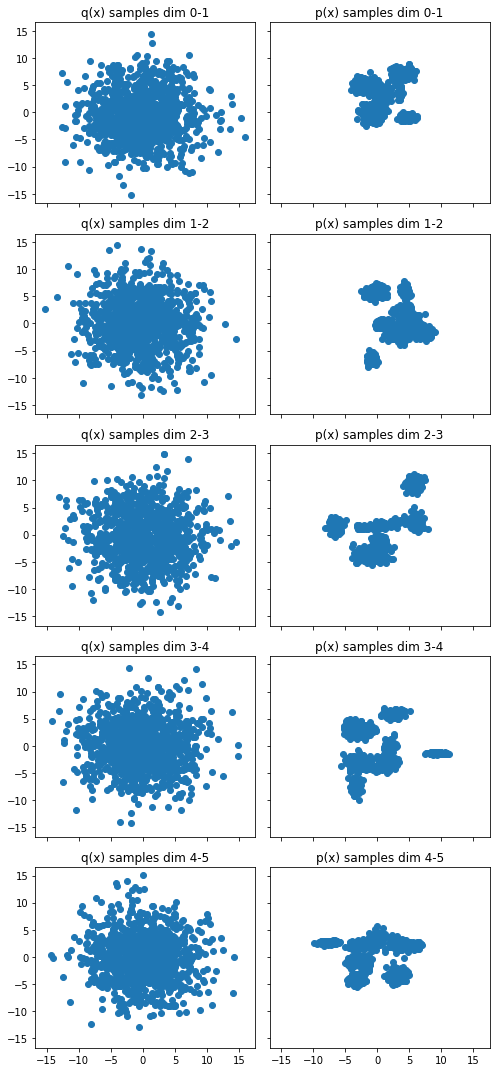

In [26]:
samples_fig_after = plot_samples(tester)

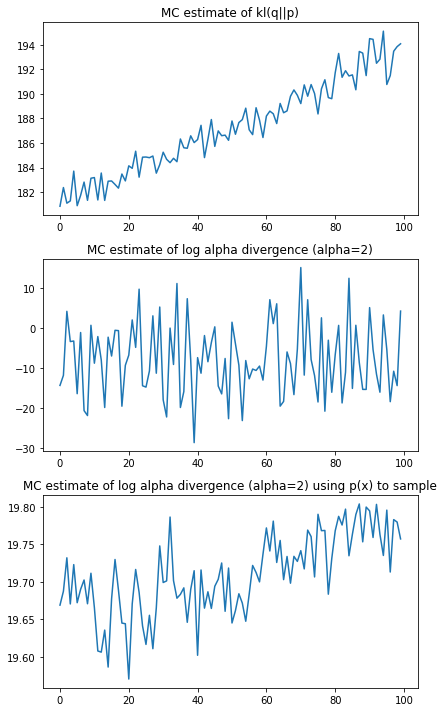

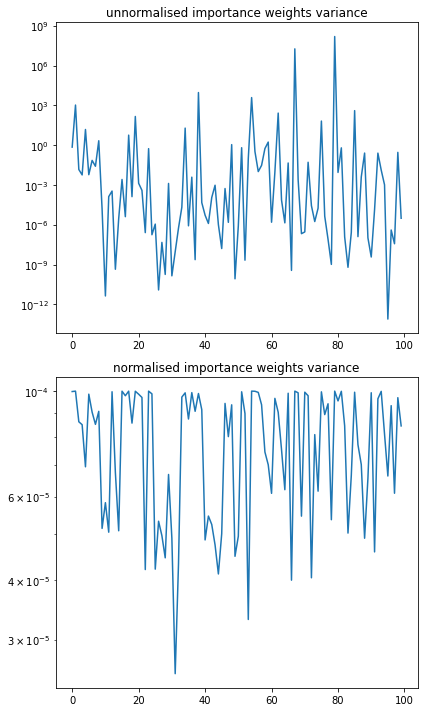

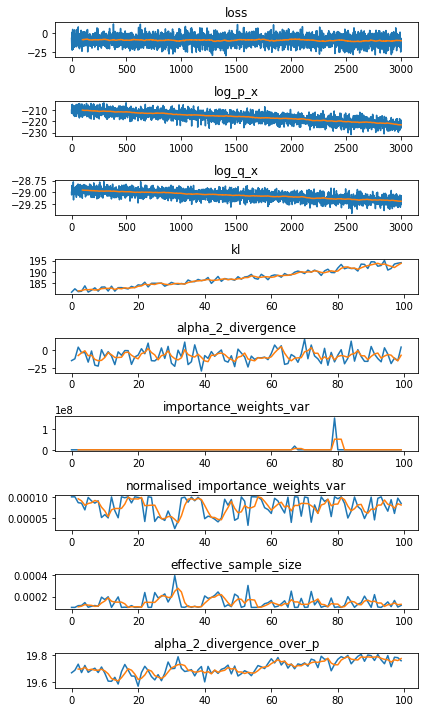

In [27]:
plot_divergences(history)
plot_sampling_info(history)
hist_plot = plot_history(history)

# KL

In [20]:
torch.manual_seed(1)
learnt_sampler_kl = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler_kl, VanillaImportanceSampling, loss_type="kl", lr=1e-3)
expectation_before_kl, info_before_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)

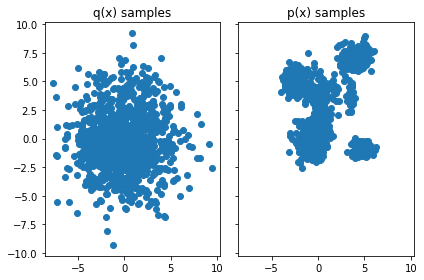

In [21]:
samples_fig_before = plot_samples(tester_kl)

In [22]:
history_kl = tester_kl.train(epochs, batch_size=batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't calculate alpha divergence over p
Couldn't ca

In [23]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 47.79381357174544 
estimate after training is -17.67390166376131 
effective sample size before is 3.419676150432436e-06
effective sample size after train is 1.6771593389581784e-05
variance in weights is 2.3849455568451536e-09


In [24]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 47.79381357174544 
estimate after training is -17.67390166376131 
effective sample size before is 3.419676150432436e-06
effective sample size after train is 1.6771593389581784e-05
variance in weights is 2.3849455568451536e-09


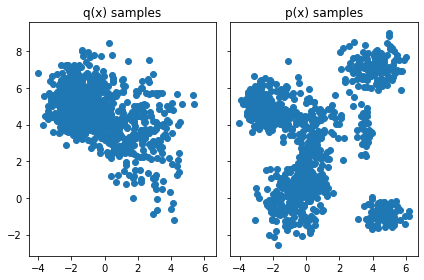

In [25]:
samples_fig_after = plot_samples(tester_kl)

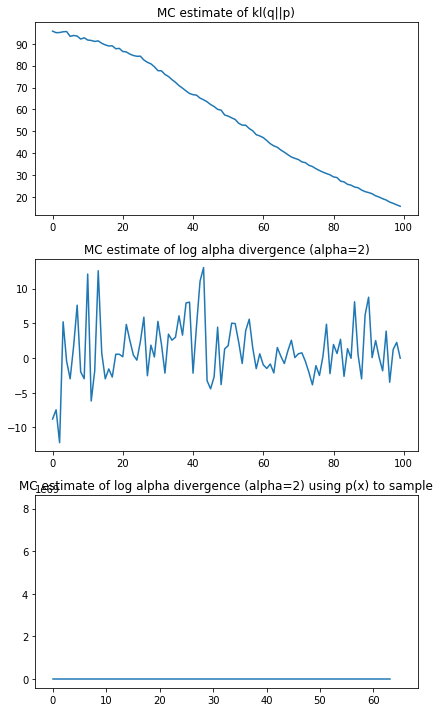

In [26]:
plot_divergences(history_kl)

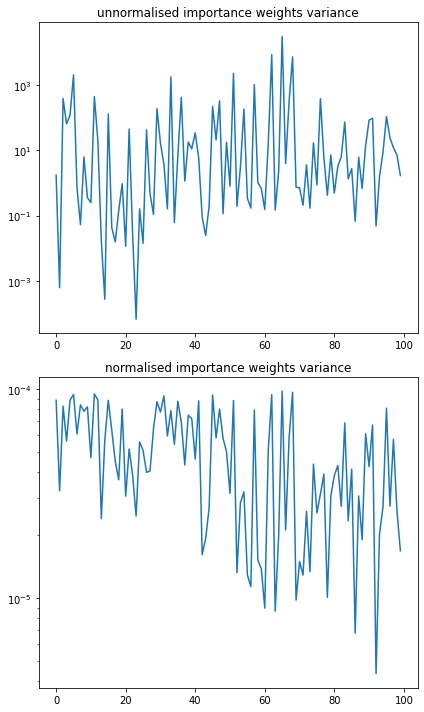

In [27]:
plot_sampling_info(history_kl)

NaN encountered in alpha_2_divergence_over_p history


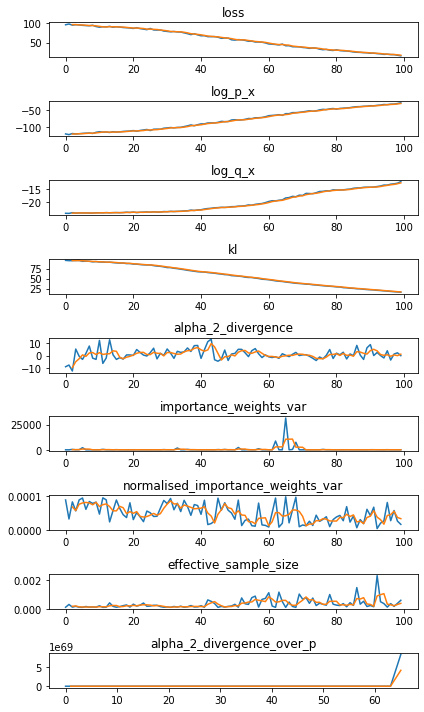

In [28]:
hist_plot = plot_history(history_kl)

# DReG, kl

In [29]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=prior_scaling_factor, flow_type=flow_type)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG_kl",
                                   lr=lr, optimizer=optimizer)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

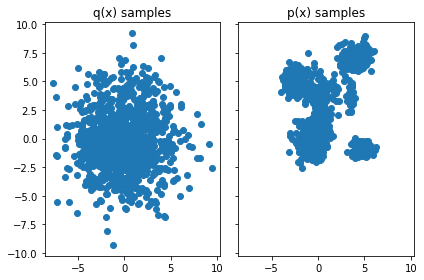

In [30]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [31]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True, max_grad_norm=1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 47.79381357174544 
estimate after training is 5.9293798115611205 
effective sample size before is 3.419676150432436e-06
effective sample size after train is 1.6245254008948862e-06
variance in weights is 2.4622540830485425e-08


In [33]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size before is {info_before['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

True expectation estimate is 20.809431185257854 
estimate before training is 47.79381357174544 
estimate after training is 5.9293798115611205 
effective sample size before is 3.419676150432436e-06
effective sample size after train is 1.6245254008948862e-06
variance in weights is 2.4622540830485425e-08


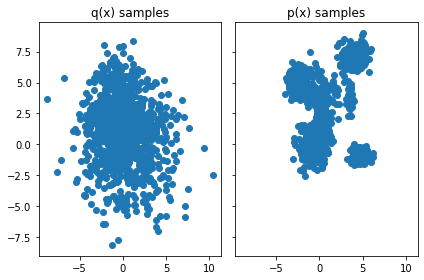

In [34]:
samples_fig_after = plot_samples(tester)

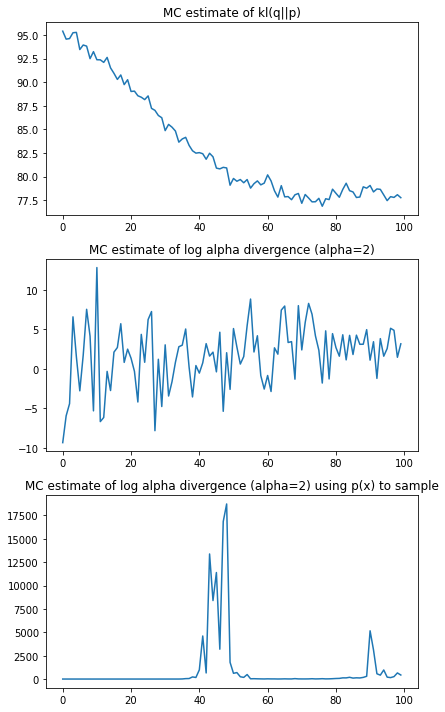

In [35]:
plot_divergences(history)

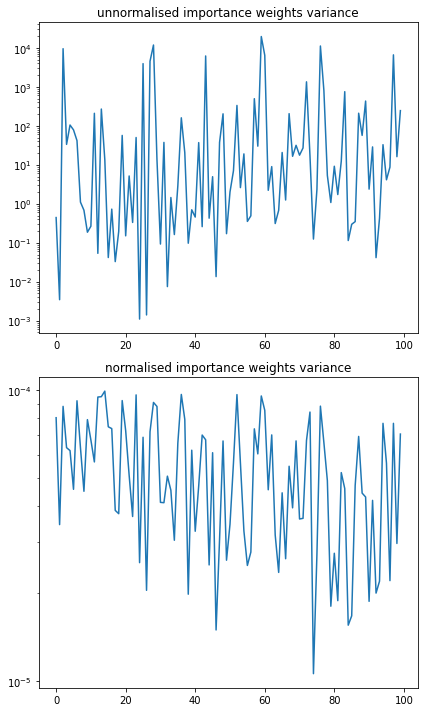

In [36]:
plot_sampling_info(history)

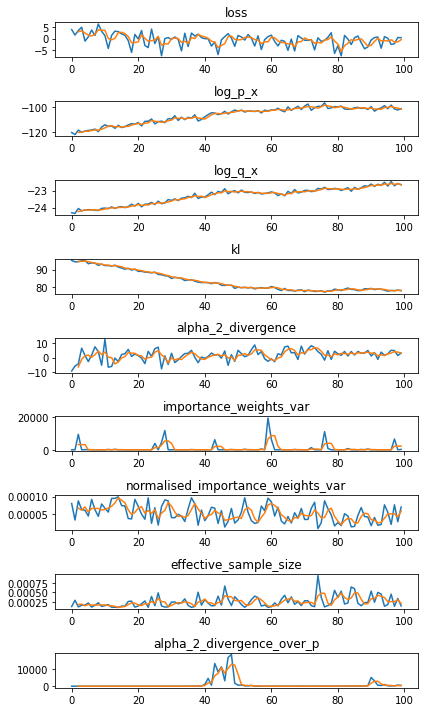

In [37]:
hist_plot = plot_history(history)